In [1]:
import pandas as pd
# Load dataset
df = pd.read_csv("Datasets/Medical-Dataset.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,56,male,43.1,2,no,southeast,13619.66
1,46,male,21.7,3,no,northwest,9641.01
2,32,male,27.8,0,yes,northeast,22904.86
3,60,male,31.4,4,no,northeast,15684.84
4,25,female,28.4,2,no,northeast,10147.21


In [2]:
# Specify columns
categorical_columns = ['sex', 'smoker', 'region']
numerical_columns = ['age', 'bmi', 'children']
target = df['charges']

In [3]:
# Split data into features and target
X = df.drop('charges', axis=1)
y = df['charges']

In [4]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [6]:
# Data Preprocessing: 
# 1. Impute missing values (if any).
# 2. OneHotEncoding for categorical columns.
# 3. StandardScaling for numerical columns.
transform_model = ColumnTransformer([
    ('ohe', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_columns),
    
    ('std', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical_columns)
])

In [7]:
from sklearn.linear_model import ElasticNet

# ElasticNet Model Pipeline
model_pipeline = Pipeline([
    ('preprocessor', transform_model),
    ('linear_model', ElasticNet(max_iter=10000, random_state=42))
])

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter search space
param_grid = {
    'linear_model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'linear_model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

# RandomizedSearchCV for faster and broader exploration
random_search = RandomizedSearchCV(model_pipeline, param_distributions=param_grid, 
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error', 
                                   random_state=42, n_jobs=-1, verbose=1)

In [9]:
# Fit model
random_search.fit(X_train, y_train)

# Best parameters from RandomizedSearchCV
print(f"Best Hyperparameters: {random_search.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'linear_model__l1_ratio': 1.0, 'linear_model__alpha': 0.1}


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate on Test Set
y_pred = random_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [11]:
# Display evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error (MSE): 983522.5864005215
Mean Absolute Error (MAE): 780.8745368263242
R2 Score: 0.9628895462757832


In [12]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Cross-validation results for a more robust evaluation
cv_scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation Mean Squared Error: {-np.mean(cv_scores)}")

Cross-Validation Mean Squared Error: 1010118.8335812073


### Actual vs Predicted Plot

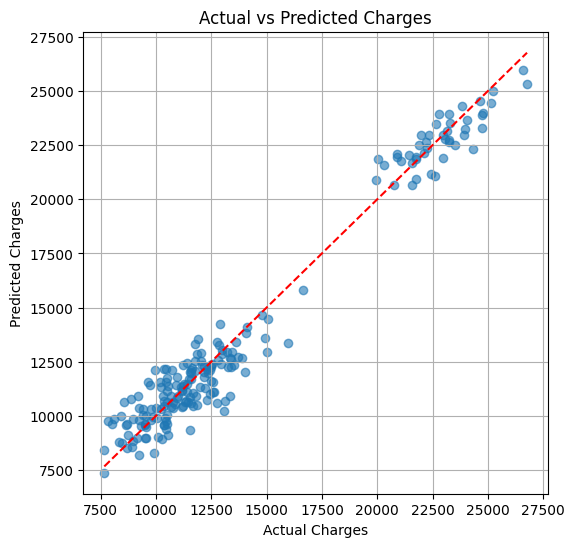

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.grid(True)
plt.show()

### Residuals Histogram
Residual = Actual − Predicted.

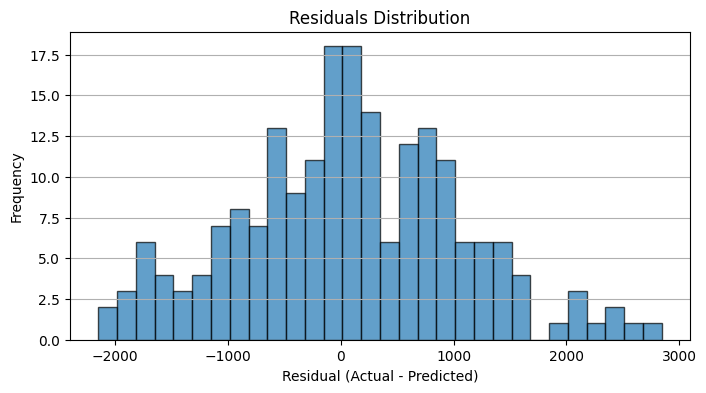

In [14]:
residuals = y_test - y_pred
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.grid(axis='y')
plt.show()

### Residuals vs Predicted Plot

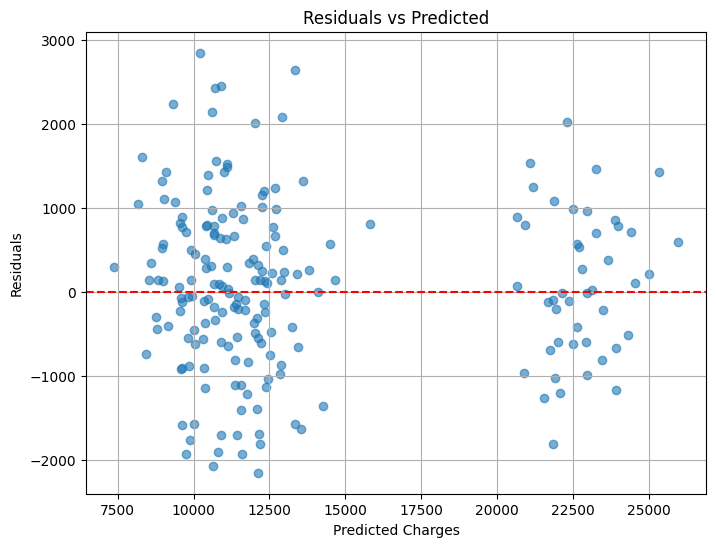

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.show()

### Feature Importance Plot (Approximate via Coefficients)

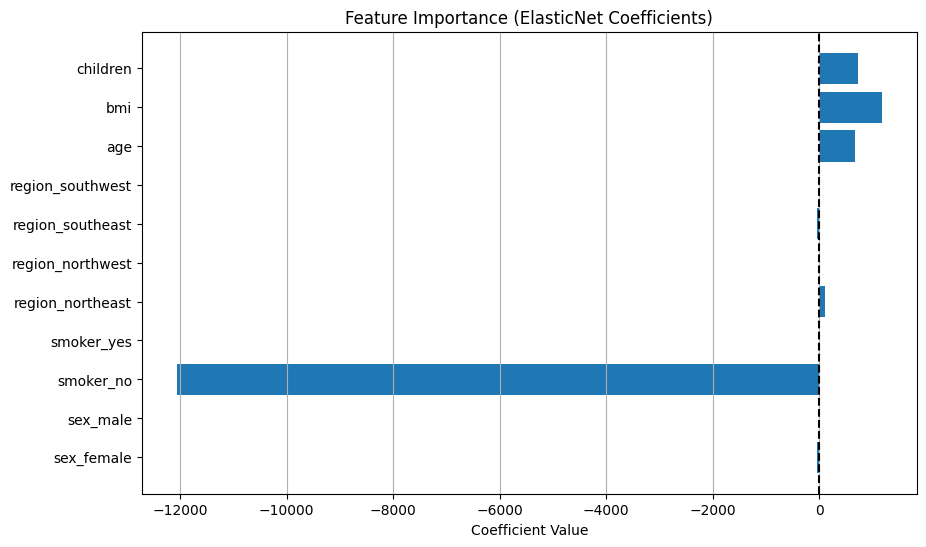

In [16]:
# Get names of all transformed features
ohe = random_search.best_estimator_.named_steps['preprocessor'].named_transformers_['ohe'].named_steps['encoder']
ohe_features = ohe.get_feature_names_out(categorical_columns)

all_feature_names = np.concatenate([ohe_features, numerical_columns])

# Get model coefficients
model_coef = random_search.best_estimator_.named_steps['linear_model'].coef_

# Plot coefficients
plt.figure(figsize=(10,6))
plt.barh(all_feature_names, model_coef)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (ElasticNet Coefficients)')
plt.axvline(0, color='k', linestyle='--')
plt.grid(axis='x')
plt.show()

In [17]:
print("Program Finished!")

Program Finished!
